In [108]:
from pynq import Overlay
import json
import numpy as np
import matplotlib.pyplot as plt
from pynq import MMIO

#load overlay
overlay = Overlay('/home/xilinx/pynq/overlays/odin/ODIN_design_wrapper.bit')

axi_dma = overlay.axi_dma_0
axi_direct_read = overlay.AXI_Direct_AEROUT_Re_0

In [109]:
from pynq import MMIO
mmio = MMIO(0x43C00000, 0x1000)

def spi_loader(spi_address, spi_data, control_bits):
    address_bits = (spi_address & 0xFFFF) | ((control_bits << 16) & 0xF0000)
    data_bits = (spi_data >> 8) & 0xFFF
    combined_data = (address_bits << 12) | data_bits

    # Write to AXI SPI Loader
    overlay.AXI_SPI_LOADER_0.write(AXI_SPI_LOADER_BASE_ADDR, combined_data)
    overlay.AXI_SPI_LOADER_0.write(AXI_SPI_LOADER_BASE_ADDR + 4, spi_data & 0xFF)
    overlay.AXI_SPI_LOADER_0.write(AXI_SPI_LOADER_BASE_ADDR + 8, 0)

    # Readout process, simulated to return some value
    readout = 0
    #while (readout & 0x80000000) == 0:
    readout = overlay.AXI_SPI_LOADER_0.read(AXI_SPI_LOADER_BASE_ADDR + 12)

    return readout & 0xFF

def spi_loader_mmio(spi_address, spi_data, control_bits):
    address_bits = (spi_address & 0xFFFF) | ((control_bits << 16) & 0xF0000)
    data_bits = (spi_data >> 8) & 0xFFF
    combined_data = (address_bits << 12) | data_bits

    # Using MMIO write commands
    mmio.write(0, combined_data)
    mmio.write(4, spi_data & 0xFF)
    mmio.write(8, 0)

    # Simulated readout process
    readout = mmio.read(12)
    return readout & 0xFF

## Parameters

In [110]:
ODIN_PROG_CONFIG = 0x00
ODIN_PROG_NEURON = 0x05
ODIN_PROG_SYNAPSE = 0x06
ODIN_READ_NEURON = 0x09
ODIN_READ_SYNAPSE = 0x0A
# Constants
AXI_SPI_LOADER_BASE_ADDR = 0x00000000  # Replace with actual base address of AXI_SPI_LOADER


SPI_GATE_ACTIVITY_ADDR = 0x00000
SPI_OPEN_LOOP_ADDR = 0x00001
SPI_SYN_SIGN_BASE_ADDR = 0x00002
SPI_BURST_TIMEREF_ADDR = 0x00012
SPI_AER_SRC_CTRL_nNEUR_ADDR = 0x00013
SPI_OUT_AER_MONITOR_EN_ADDR = 0x00014
SPI_MONITOR_NEUR_ADDR_ADDR = 0x00015
SPI_MONITOR_SYN_ADDR_ADDR = 0x00016
SPI_UPDATE_UNMAPPED_SYN_ADDR = 0x00017
SPI_PROPAGATE_UNMAPPED_SYN_ADDR = 0x00018
SPI_SDSP_ON_SYN_STIM_ADDR = 0x00019

# Configuration Code

In [111]:


addr_data_pairs = [
    {"addr": SPI_GATE_ACTIVITY_ADDR, "data": 0x00001},
    {"addr": SPI_OPEN_LOOP_ADDR, "data": 0x00001},
]

for i in range(16):
    addr_data_pairs.append({"addr": SPI_SYN_SIGN_BASE_ADDR + i, "data": 0x00000})

addr_data_pairs.extend([
    {"addr": SPI_BURST_TIMEREF_ADDR, "data": 0x00000},
    {"addr": SPI_AER_SRC_CTRL_nNEUR_ADDR, "data": 0x00000},
    {"addr": SPI_OUT_AER_MONITOR_EN_ADDR, "data": 0x00000},
    {"addr": SPI_MONITOR_NEUR_ADDR_ADDR, "data": 0x00000},
    {"addr": SPI_MONITOR_SYN_ADDR_ADDR, "data": 0x00000},
    {"addr": SPI_UPDATE_UNMAPPED_SYN_ADDR, "data": 0x00000},
    {"addr": SPI_PROPAGATE_UNMAPPED_SYN_ADDR, "data": 0x00000},
    {"addr": SPI_SDSP_ON_SYN_STIM_ADDR, "data": 0x00000},
])

#Write all configuration registers
for pair in addr_data_pairs:
    read_byte = spi_loader_mmio(pair['addr'], pair['data'], ODIN_PROG_CONFIG)


## Neuron Write Self Test

In [112]:
import random

# Write data to the SPI registers
def write_neuron_data(n_range=256):
    for neuron_idx in range(n_range):  # Adjust range as needed
        for byte_idx in range(16):
            address = (neuron_idx) | ((byte_idx & 0xFF) << 8)
            byte_data = (neuron_data[neuron_idx][(15 - byte_idx) // 4] >> ((byte_idx % 4) * 8)) & 0xFF
            int_data = 0x000000FF & byte_data
            spi_loader_mmio(address, int_data, ODIN_PROG_NEURON)

# Read data back from the SPI registers for verification
def read_neuron_data(n_range=256):
    read_data = [[0 for _ in range(4)] for _ in range(n_range)]  # Adjust range as needed
    for neuron_idx in range(n_range):
        for byte_idx in range(16):
            address = (neuron_idx) | ((byte_idx & 0xFF) << 8)
            read_byte = spi_loader_mmio(address, 0, ODIN_READ_NEURON)
            int_pos = (15 - byte_idx) // 4
            byte_pos = (byte_idx % 4) * 8
            read_data[neuron_idx][int_pos] |= (read_byte << byte_pos)
    return read_data

def verify_data(original, readback, verbose = False):
    for neuron_idx in range(len(original)):
        if verbose:
            print("Wrote: {}, Read: {}".format(original[neuron_idx], readback[neuron_idx]))
        for int_idx in range(4):
            if original[neuron_idx][int_idx] != readback[neuron_idx][int_idx]:
                print(f"Mismatch at neuron {neuron_idx}, int {int_idx}: original 0x{original[neuron_idx][int_idx]:08X}, readback 0x{readback[neuron_idx][int_idx]:08X}")
                return False
    return True

#Random neuron data
neuron_data = [[random.randint(0, 0xFFFFFFFF) for _ in range(4)] for _ in range(256)]

#Open Programmer
spi_loader_mmio(SPI_GATE_ACTIVITY_ADDR, 1, ODIN_PROG_CONFIG)

write_neuron_data()
read_back_data = read_neuron_data()

#Close Programmer
spi_loader_mmio(SPI_GATE_ACTIVITY_ADDR, 0, ODIN_PROG_CONFIG)

if verify_data(neuron_data, read_back_data, False):
    print("Verification Passed")
else:
    print("Verification Failed")

Verification Passed


## Verify AER data format

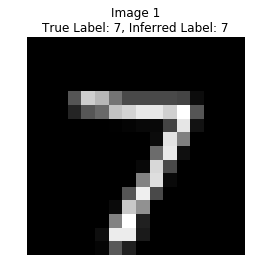

AER Code:
[215, 91, 184, 230, 231, 138, 88, 89, 107, 122, 169, 153, 87, 90, 68, 199, 86, 69, 200, 168, 214, 123, 70, 137, 85, 246, 84, 92, 67, 183, 154, 74, 73, 71, 72, 185, 75, 106, 83, 247, 216, 232, 108, 139, 229, 76, 121, 198, 170, 152, 104, 105, 245, 103, 102, 213, 109, 110, 66, 65, 64, 63, 61, 98, 101, 100, 99, 77, 97, 96, 78, 79, 80, 81, 82, 95, 94, 93, 62, 255, 60, 15, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 14, 59, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 29, 30, 31, 32, 58, 57, 56, 55, 112, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 111, 127, 113, 182, 218, 217, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 219, 220, 221, 239, 253, 252, 251, 250, 249, 248, 244, 243, 242, 241, 240, 238, 222, 237, 236, 235, 234, 233, 228, 227, 226, 225, 224, 223, 186, 181, 114, 180, 145, 144, 143, 142, 141, 140, 136, 135, 134, 133, 132, 131, 130, 129, 128, 254, 126, 12

In [113]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load AER data from JSON file
with open("data/aer_data.json", "r") as json_file:
    aer_data = json.load(json_file)["aer_data"]

# Load synapse data from JSON file
with open("data/synapse_data.json", "r") as json_file:
    synapse_data = json.load(json_file)

# Get the 4th image data
image_data = aer_data[0]
image_index = image_data["image_index"]
true_label = image_data["true_label"]
inferred_label = image_data["inferred_label"]
aer_code = image_data["aer_data"]
original_image = np.array(image_data["original_image"]).reshape(16, 16)

# Display the 4th original image
plt.imshow(original_image, cmap="gray")
plt.title(f"Image {image_index}\nTrue Label: {true_label}, Inferred Label: {inferred_label}")
plt.axis("off")
plt.show()

# Print the AER code for the 4th image
print("AER Code:")
print(aer_code)

# Print the first four bytes from the synapse data
print("\nSynapse Data (First 4 Bytes):")
for i in range(4):
    byte_data = synapse_data[i]
    byte_value = int(byte_data, 2)
    print(f"Byte {i + 1}: {byte_data} (Decimal: {byte_value})")

### Timing test. Using MMIO is MUCH faster than using .write() and .read(). Not important for operation, can skip.

In [114]:
#Timint test
from my_decorators import timing
spi_loader(0, 1, ODIN_PROG_CONFIG)  


@timing
def read_neuron_data():
    for neuron_idx in range(1):
        for byte_idx in range(16):
            address = (neuron_idx) | ((byte_idx & 0xFF) << 8)
            read_byte = spi_loader(address, 0, ODIN_READ_NEURON)  # Modify as per your specific protocol
            print(f"Address: 0x{address:05X}, Read Byte: 0x{read_byte:02X}")

@timing
def read_neuron_data_mmio():
    for neuron_idx in range(1):
        for byte_idx in range(16):
            address = (neuron_idx) | ((byte_idx & 0xFF) << 8)
            read_byte = spi_loader_mmio(address, 0, ODIN_READ_NEURON)  # Modify as per your specific protocol
            print(f"Address: 0x{address:05X}, Read Byte: 0x{read_byte:02X}")

read_neuron_data()
read_neuron_data_mmio()

Address: 0x00000, Read Byte: 0xC9
Address: 0x00100, Read Byte: 0xA7
Address: 0x00200, Read Byte: 0xDB
Address: 0x00300, Read Byte: 0x3C
Address: 0x00400, Read Byte: 0xA3
Address: 0x00500, Read Byte: 0xDD
Address: 0x00600, Read Byte: 0x4F
Address: 0x00700, Read Byte: 0xBD
Address: 0x00800, Read Byte: 0xFD
Address: 0x00900, Read Byte: 0x96
Address: 0x00A00, Read Byte: 0x10
Address: 0x00B00, Read Byte: 0x4E
Address: 0x00C00, Read Byte: 0xA5
Address: 0x00D00, Read Byte: 0xA6
Address: 0x00E00, Read Byte: 0xCB
Address: 0x00F00, Read Byte: 0xE1
read_neuron_data took 0.64474955 seconds
Address: 0x00000, Read Byte: 0xC9
Address: 0x00100, Read Byte: 0xA7
Address: 0x00200, Read Byte: 0xDB
Address: 0x00300, Read Byte: 0x3C
Address: 0x00400, Read Byte: 0xA3
Address: 0x00500, Read Byte: 0xDD
Address: 0x00600, Read Byte: 0x4F
Address: 0x00700, Read Byte: 0xBD
Address: 0x00800, Read Byte: 0xFD
Address: 0x00900, Read Byte: 0x96
Address: 0x00A00, Read Byte: 0x10
Address: 0x00B00, Read Byte: 0x4E
Address

# Load Neurons

In [115]:
import json

# Function to split 128-bit data into 8-bit chunks
def split_data(data):
    return [data[i:i+8] for i in range(0, len(data), 8)][::-1]

# Read the neuron data from the JSON file
with open("data/neuron_data.json", "r") as file:
    data = json.load(file)
    neuron_data = data["neuron_data"]
    
spi_loader(0, 1, ODIN_PROG_CONFIG)
# Iterate over each neuron configuration
for neuron_index, binary_config in enumerate(neuron_data[:]):
    # Split the 128-bit binary configuration into 8-bit chunks
    chunks = split_data(binary_config)
    
    # Load each 8-bit chunk using the spi_loader function
    for chunk_index, chunk in enumerate(chunks):
        spi_address = (chunk_index << 8) + neuron_index
        spi_data = int(chunk, 2)
        
        # Call the spi_loader function to load the data
        readout = spi_loader_mmio(spi_address, spi_data, ODIN_PROG_NEURON)
        
        # Print the loaded data for verification
        #print(f"Neuron {neuron_index}, Chunk {chunk_index}: Loaded {chunk} (Address: {spi_address:04X}, Data: {spi_data:02X})")
    
    print(f"Finished loading neuron {neuron_index}")
spi_loader(0, 0, ODIN_PROG_CONFIG)  

Finished loading neuron 0
Finished loading neuron 1
Finished loading neuron 2
Finished loading neuron 3
Finished loading neuron 4
Finished loading neuron 5
Finished loading neuron 6
Finished loading neuron 7
Finished loading neuron 8
Finished loading neuron 9
Finished loading neuron 10
Finished loading neuron 11
Finished loading neuron 12
Finished loading neuron 13
Finished loading neuron 14
Finished loading neuron 15
Finished loading neuron 16
Finished loading neuron 17
Finished loading neuron 18
Finished loading neuron 19
Finished loading neuron 20
Finished loading neuron 21
Finished loading neuron 22
Finished loading neuron 23
Finished loading neuron 24
Finished loading neuron 25
Finished loading neuron 26
Finished loading neuron 27
Finished loading neuron 28
Finished loading neuron 29
Finished loading neuron 30
Finished loading neuron 31
Finished loading neuron 32
Finished loading neuron 33
Finished loading neuron 34
Finished loading neuron 35
Finished loading neuron 36
Finished lo

0

# Load Synapse Weights

In [116]:
with open("data/synapse_data.json", "r") as file:
    synapse_data = json.load(file)
    
spi_loader_mmio(0, 1, ODIN_PROG_CONFIG)  
for synapse_index, binary_config in enumerate(synapse_data[:]):
    # Split the 128-bit binary configuration into 8-bit chunks
    chunks = split_data(binary_config)
    
    # Load each 8-bit chunk using the spi_loader function
    for chunk_index, chunk in enumerate(chunks):
        spi_address = (chunk_index << 13) + synapse_index
        spi_data = int(chunk, 2)
        #print(hex(spi_address), spi_data)
        # Call the spi_loader function to load the data
        spi_loader_mmio(spi_address, spi_data, ODIN_PROG_SYNAPSE)
        
        # Print the loaded data for verification
        #print(f"Neuron {neuron_index}, Chunk {chunk_index}: Loaded {chunk} (Address: {spi_address:04X}, Data: {spi_data:02X})")
    
    print(f"Finished loading synapse {synapse_index}")
spi_loader_mmio(0, 0, ODIN_PROG_CONFIG)  

Finished loading synapse 0
Finished loading synapse 1
Finished loading synapse 2
Finished loading synapse 3
Finished loading synapse 4
Finished loading synapse 5
Finished loading synapse 6
Finished loading synapse 7
Finished loading synapse 8
Finished loading synapse 9
Finished loading synapse 10
Finished loading synapse 11
Finished loading synapse 12
Finished loading synapse 13
Finished loading synapse 14
Finished loading synapse 15
Finished loading synapse 16
Finished loading synapse 17
Finished loading synapse 18
Finished loading synapse 19
Finished loading synapse 20
Finished loading synapse 21
Finished loading synapse 22
Finished loading synapse 23
Finished loading synapse 24
Finished loading synapse 25
Finished loading synapse 26
Finished loading synapse 27
Finished loading synapse 28
Finished loading synapse 29
Finished loading synapse 30
Finished loading synapse 31
Finished loading synapse 32
Finished loading synapse 33
Finished loading synapse 34
Finished loading synapse 35
Fi

Finished loading synapse 424
Finished loading synapse 425
Finished loading synapse 426
Finished loading synapse 427
Finished loading synapse 428
Finished loading synapse 429
Finished loading synapse 430
Finished loading synapse 431
Finished loading synapse 432
Finished loading synapse 433
Finished loading synapse 434
Finished loading synapse 435
Finished loading synapse 436
Finished loading synapse 437
Finished loading synapse 438
Finished loading synapse 439
Finished loading synapse 440
Finished loading synapse 441
Finished loading synapse 442
Finished loading synapse 443
Finished loading synapse 444
Finished loading synapse 445
Finished loading synapse 446
Finished loading synapse 447
Finished loading synapse 448
Finished loading synapse 449
Finished loading synapse 450
Finished loading synapse 451
Finished loading synapse 452
Finished loading synapse 453
Finished loading synapse 454
Finished loading synapse 455
Finished loading synapse 456
Finished loading synapse 457
Finished loadi

Finished loading synapse 790
Finished loading synapse 791
Finished loading synapse 792
Finished loading synapse 793
Finished loading synapse 794
Finished loading synapse 795
Finished loading synapse 796
Finished loading synapse 797
Finished loading synapse 798
Finished loading synapse 799
Finished loading synapse 800
Finished loading synapse 801
Finished loading synapse 802
Finished loading synapse 803
Finished loading synapse 804
Finished loading synapse 805
Finished loading synapse 806
Finished loading synapse 807
Finished loading synapse 808
Finished loading synapse 809
Finished loading synapse 810
Finished loading synapse 811
Finished loading synapse 812
Finished loading synapse 813
Finished loading synapse 814
Finished loading synapse 815
Finished loading synapse 816
Finished loading synapse 817
Finished loading synapse 818
Finished loading synapse 819
Finished loading synapse 820
Finished loading synapse 821
Finished loading synapse 822
Finished loading synapse 823
Finished loadi

Finished loading synapse 1154
Finished loading synapse 1155
Finished loading synapse 1156
Finished loading synapse 1157
Finished loading synapse 1158
Finished loading synapse 1159
Finished loading synapse 1160
Finished loading synapse 1161
Finished loading synapse 1162
Finished loading synapse 1163
Finished loading synapse 1164
Finished loading synapse 1165
Finished loading synapse 1166
Finished loading synapse 1167
Finished loading synapse 1168
Finished loading synapse 1169
Finished loading synapse 1170
Finished loading synapse 1171
Finished loading synapse 1172
Finished loading synapse 1173
Finished loading synapse 1174
Finished loading synapse 1175
Finished loading synapse 1176
Finished loading synapse 1177
Finished loading synapse 1178
Finished loading synapse 1179
Finished loading synapse 1180
Finished loading synapse 1181
Finished loading synapse 1182
Finished loading synapse 1183
Finished loading synapse 1184
Finished loading synapse 1185
Finished loading synapse 1186
Finished l

Finished loading synapse 1504
Finished loading synapse 1505
Finished loading synapse 1506
Finished loading synapse 1507
Finished loading synapse 1508
Finished loading synapse 1509
Finished loading synapse 1510
Finished loading synapse 1511
Finished loading synapse 1512
Finished loading synapse 1513
Finished loading synapse 1514
Finished loading synapse 1515
Finished loading synapse 1516
Finished loading synapse 1517
Finished loading synapse 1518
Finished loading synapse 1519
Finished loading synapse 1520
Finished loading synapse 1521
Finished loading synapse 1522
Finished loading synapse 1523
Finished loading synapse 1524
Finished loading synapse 1525
Finished loading synapse 1526
Finished loading synapse 1527
Finished loading synapse 1528
Finished loading synapse 1529
Finished loading synapse 1530
Finished loading synapse 1531
Finished loading synapse 1532
Finished loading synapse 1533
Finished loading synapse 1534
Finished loading synapse 1535
Finished loading synapse 1536
Finished l

Finished loading synapse 1787
Finished loading synapse 1788
Finished loading synapse 1789
Finished loading synapse 1790
Finished loading synapse 1791
Finished loading synapse 1792
Finished loading synapse 1793
Finished loading synapse 1794
Finished loading synapse 1795
Finished loading synapse 1796
Finished loading synapse 1797
Finished loading synapse 1798
Finished loading synapse 1799
Finished loading synapse 1800
Finished loading synapse 1801
Finished loading synapse 1802
Finished loading synapse 1803
Finished loading synapse 1804
Finished loading synapse 1805
Finished loading synapse 1806
Finished loading synapse 1807
Finished loading synapse 1808
Finished loading synapse 1809
Finished loading synapse 1810
Finished loading synapse 1811
Finished loading synapse 1812
Finished loading synapse 1813
Finished loading synapse 1814
Finished loading synapse 1815
Finished loading synapse 1816
Finished loading synapse 1817
Finished loading synapse 1818
Finished loading synapse 1819
Finished l

Finished loading synapse 2216
Finished loading synapse 2217
Finished loading synapse 2218
Finished loading synapse 2219
Finished loading synapse 2220
Finished loading synapse 2221
Finished loading synapse 2222
Finished loading synapse 2223
Finished loading synapse 2224
Finished loading synapse 2225
Finished loading synapse 2226
Finished loading synapse 2227
Finished loading synapse 2228
Finished loading synapse 2229
Finished loading synapse 2230
Finished loading synapse 2231
Finished loading synapse 2232
Finished loading synapse 2233
Finished loading synapse 2234
Finished loading synapse 2235
Finished loading synapse 2236
Finished loading synapse 2237
Finished loading synapse 2238
Finished loading synapse 2239
Finished loading synapse 2240
Finished loading synapse 2241
Finished loading synapse 2242
Finished loading synapse 2243
Finished loading synapse 2244
Finished loading synapse 2245
Finished loading synapse 2246
Finished loading synapse 2247
Finished loading synapse 2248
Finished l

Finished loading synapse 2498
Finished loading synapse 2499
Finished loading synapse 2500
Finished loading synapse 2501
Finished loading synapse 2502
Finished loading synapse 2503
Finished loading synapse 2504
Finished loading synapse 2505
Finished loading synapse 2506
Finished loading synapse 2507
Finished loading synapse 2508
Finished loading synapse 2509
Finished loading synapse 2510
Finished loading synapse 2511
Finished loading synapse 2512
Finished loading synapse 2513
Finished loading synapse 2514
Finished loading synapse 2515
Finished loading synapse 2516
Finished loading synapse 2517
Finished loading synapse 2518
Finished loading synapse 2519
Finished loading synapse 2520
Finished loading synapse 2521
Finished loading synapse 2522
Finished loading synapse 2523
Finished loading synapse 2524
Finished loading synapse 2525
Finished loading synapse 2526
Finished loading synapse 2527
Finished loading synapse 2528
Finished loading synapse 2529
Finished loading synapse 2530
Finished l

Finished loading synapse 2784
Finished loading synapse 2785
Finished loading synapse 2786
Finished loading synapse 2787
Finished loading synapse 2788
Finished loading synapse 2789
Finished loading synapse 2790
Finished loading synapse 2791
Finished loading synapse 2792
Finished loading synapse 2793
Finished loading synapse 2794
Finished loading synapse 2795
Finished loading synapse 2796
Finished loading synapse 2797
Finished loading synapse 2798
Finished loading synapse 2799
Finished loading synapse 2800
Finished loading synapse 2801
Finished loading synapse 2802
Finished loading synapse 2803
Finished loading synapse 2804
Finished loading synapse 2805
Finished loading synapse 2806
Finished loading synapse 2807
Finished loading synapse 2808
Finished loading synapse 2809
Finished loading synapse 2810
Finished loading synapse 2811
Finished loading synapse 2812
Finished loading synapse 2813
Finished loading synapse 2814
Finished loading synapse 2815
Finished loading synapse 2816
Finished l

Finished loading synapse 3222
Finished loading synapse 3223
Finished loading synapse 3224
Finished loading synapse 3225
Finished loading synapse 3226
Finished loading synapse 3227
Finished loading synapse 3228
Finished loading synapse 3229
Finished loading synapse 3230
Finished loading synapse 3231
Finished loading synapse 3232
Finished loading synapse 3233
Finished loading synapse 3234
Finished loading synapse 3235
Finished loading synapse 3236
Finished loading synapse 3237
Finished loading synapse 3238
Finished loading synapse 3239
Finished loading synapse 3240
Finished loading synapse 3241
Finished loading synapse 3242
Finished loading synapse 3243
Finished loading synapse 3244
Finished loading synapse 3245
Finished loading synapse 3246
Finished loading synapse 3247
Finished loading synapse 3248
Finished loading synapse 3249
Finished loading synapse 3250
Finished loading synapse 3251
Finished loading synapse 3252
Finished loading synapse 3253
Finished loading synapse 3254
Finished l

Finished loading synapse 3716
Finished loading synapse 3717
Finished loading synapse 3718
Finished loading synapse 3719
Finished loading synapse 3720
Finished loading synapse 3721
Finished loading synapse 3722
Finished loading synapse 3723
Finished loading synapse 3724
Finished loading synapse 3725
Finished loading synapse 3726
Finished loading synapse 3727
Finished loading synapse 3728
Finished loading synapse 3729
Finished loading synapse 3730
Finished loading synapse 3731
Finished loading synapse 3732
Finished loading synapse 3733
Finished loading synapse 3734
Finished loading synapse 3735
Finished loading synapse 3736
Finished loading synapse 3737
Finished loading synapse 3738
Finished loading synapse 3739
Finished loading synapse 3740
Finished loading synapse 3741
Finished loading synapse 3742
Finished loading synapse 3743
Finished loading synapse 3744
Finished loading synapse 3745
Finished loading synapse 3746
Finished loading synapse 3747
Finished loading synapse 3748
Finished l

Finished loading synapse 4210
Finished loading synapse 4211
Finished loading synapse 4212
Finished loading synapse 4213
Finished loading synapse 4214
Finished loading synapse 4215
Finished loading synapse 4216
Finished loading synapse 4217
Finished loading synapse 4218
Finished loading synapse 4219
Finished loading synapse 4220
Finished loading synapse 4221
Finished loading synapse 4222
Finished loading synapse 4223
Finished loading synapse 4224
Finished loading synapse 4225
Finished loading synapse 4226
Finished loading synapse 4227
Finished loading synapse 4228
Finished loading synapse 4229
Finished loading synapse 4230
Finished loading synapse 4231
Finished loading synapse 4232
Finished loading synapse 4233
Finished loading synapse 4234
Finished loading synapse 4235
Finished loading synapse 4236
Finished loading synapse 4237
Finished loading synapse 4238
Finished loading synapse 4239
Finished loading synapse 4240
Finished loading synapse 4241
Finished loading synapse 4242
Finished l

Finished loading synapse 4493
Finished loading synapse 4494
Finished loading synapse 4495
Finished loading synapse 4496
Finished loading synapse 4497
Finished loading synapse 4498
Finished loading synapse 4499
Finished loading synapse 4500
Finished loading synapse 4501
Finished loading synapse 4502
Finished loading synapse 4503
Finished loading synapse 4504
Finished loading synapse 4505
Finished loading synapse 4506
Finished loading synapse 4507
Finished loading synapse 4508
Finished loading synapse 4509
Finished loading synapse 4510
Finished loading synapse 4511
Finished loading synapse 4512
Finished loading synapse 4513
Finished loading synapse 4514
Finished loading synapse 4515
Finished loading synapse 4516
Finished loading synapse 4517
Finished loading synapse 4518
Finished loading synapse 4519
Finished loading synapse 4520
Finished loading synapse 4521
Finished loading synapse 4522
Finished loading synapse 4523
Finished loading synapse 4524
Finished loading synapse 4525
Finished l

Finished loading synapse 4778
Finished loading synapse 4779
Finished loading synapse 4780
Finished loading synapse 4781
Finished loading synapse 4782
Finished loading synapse 4783
Finished loading synapse 4784
Finished loading synapse 4785
Finished loading synapse 4786
Finished loading synapse 4787
Finished loading synapse 4788
Finished loading synapse 4789
Finished loading synapse 4790
Finished loading synapse 4791
Finished loading synapse 4792
Finished loading synapse 4793
Finished loading synapse 4794
Finished loading synapse 4795
Finished loading synapse 4796
Finished loading synapse 4797
Finished loading synapse 4798
Finished loading synapse 4799
Finished loading synapse 4800
Finished loading synapse 4801
Finished loading synapse 4802
Finished loading synapse 4803
Finished loading synapse 4804
Finished loading synapse 4805
Finished loading synapse 4806
Finished loading synapse 4807
Finished loading synapse 4808
Finished loading synapse 4809
Finished loading synapse 4810
Finished l

Finished loading synapse 5214
Finished loading synapse 5215
Finished loading synapse 5216
Finished loading synapse 5217
Finished loading synapse 5218
Finished loading synapse 5219
Finished loading synapse 5220
Finished loading synapse 5221
Finished loading synapse 5222
Finished loading synapse 5223
Finished loading synapse 5224
Finished loading synapse 5225
Finished loading synapse 5226
Finished loading synapse 5227
Finished loading synapse 5228
Finished loading synapse 5229
Finished loading synapse 5230
Finished loading synapse 5231
Finished loading synapse 5232
Finished loading synapse 5233
Finished loading synapse 5234
Finished loading synapse 5235
Finished loading synapse 5236
Finished loading synapse 5237
Finished loading synapse 5238
Finished loading synapse 5239
Finished loading synapse 5240
Finished loading synapse 5241
Finished loading synapse 5242
Finished loading synapse 5243
Finished loading synapse 5244
Finished loading synapse 5245
Finished loading synapse 5246
Finished l

Finished loading synapse 5492
Finished loading synapse 5493
Finished loading synapse 5494
Finished loading synapse 5495
Finished loading synapse 5496
Finished loading synapse 5497
Finished loading synapse 5498
Finished loading synapse 5499
Finished loading synapse 5500
Finished loading synapse 5501
Finished loading synapse 5502
Finished loading synapse 5503
Finished loading synapse 5504
Finished loading synapse 5505
Finished loading synapse 5506
Finished loading synapse 5507
Finished loading synapse 5508
Finished loading synapse 5509
Finished loading synapse 5510
Finished loading synapse 5511
Finished loading synapse 5512
Finished loading synapse 5513
Finished loading synapse 5514
Finished loading synapse 5515
Finished loading synapse 5516
Finished loading synapse 5517
Finished loading synapse 5518
Finished loading synapse 5519
Finished loading synapse 5520
Finished loading synapse 5521
Finished loading synapse 5522
Finished loading synapse 5523
Finished loading synapse 5524
Finished l

Finished loading synapse 5775
Finished loading synapse 5776
Finished loading synapse 5777
Finished loading synapse 5778
Finished loading synapse 5779
Finished loading synapse 5780
Finished loading synapse 5781
Finished loading synapse 5782
Finished loading synapse 5783
Finished loading synapse 5784
Finished loading synapse 5785
Finished loading synapse 5786
Finished loading synapse 5787
Finished loading synapse 5788
Finished loading synapse 5789
Finished loading synapse 5790
Finished loading synapse 5791
Finished loading synapse 5792
Finished loading synapse 5793
Finished loading synapse 5794
Finished loading synapse 5795
Finished loading synapse 5796
Finished loading synapse 5797
Finished loading synapse 5798
Finished loading synapse 5799
Finished loading synapse 5800
Finished loading synapse 5801
Finished loading synapse 5802
Finished loading synapse 5803
Finished loading synapse 5804
Finished loading synapse 5805
Finished loading synapse 5806
Finished loading synapse 5807
Finished l

Finished loading synapse 6209
Finished loading synapse 6210
Finished loading synapse 6211
Finished loading synapse 6212
Finished loading synapse 6213
Finished loading synapse 6214
Finished loading synapse 6215
Finished loading synapse 6216
Finished loading synapse 6217
Finished loading synapse 6218
Finished loading synapse 6219
Finished loading synapse 6220
Finished loading synapse 6221
Finished loading synapse 6222
Finished loading synapse 6223
Finished loading synapse 6224
Finished loading synapse 6225
Finished loading synapse 6226
Finished loading synapse 6227
Finished loading synapse 6228
Finished loading synapse 6229
Finished loading synapse 6230
Finished loading synapse 6231
Finished loading synapse 6232
Finished loading synapse 6233
Finished loading synapse 6234
Finished loading synapse 6235
Finished loading synapse 6236
Finished loading synapse 6237
Finished loading synapse 6238
Finished loading synapse 6239
Finished loading synapse 6240
Finished loading synapse 6241
Finished l

Finished loading synapse 6486
Finished loading synapse 6487
Finished loading synapse 6488
Finished loading synapse 6489
Finished loading synapse 6490
Finished loading synapse 6491
Finished loading synapse 6492
Finished loading synapse 6493
Finished loading synapse 6494
Finished loading synapse 6495
Finished loading synapse 6496
Finished loading synapse 6497
Finished loading synapse 6498
Finished loading synapse 6499
Finished loading synapse 6500
Finished loading synapse 6501
Finished loading synapse 6502
Finished loading synapse 6503
Finished loading synapse 6504
Finished loading synapse 6505
Finished loading synapse 6506
Finished loading synapse 6507
Finished loading synapse 6508
Finished loading synapse 6509
Finished loading synapse 6510
Finished loading synapse 6511
Finished loading synapse 6512
Finished loading synapse 6513
Finished loading synapse 6514
Finished loading synapse 6515
Finished loading synapse 6516
Finished loading synapse 6517
Finished loading synapse 6518
Finished l

Finished loading synapse 6772
Finished loading synapse 6773
Finished loading synapse 6774
Finished loading synapse 6775
Finished loading synapse 6776
Finished loading synapse 6777
Finished loading synapse 6778
Finished loading synapse 6779
Finished loading synapse 6780
Finished loading synapse 6781
Finished loading synapse 6782
Finished loading synapse 6783
Finished loading synapse 6784
Finished loading synapse 6785
Finished loading synapse 6786
Finished loading synapse 6787
Finished loading synapse 6788
Finished loading synapse 6789
Finished loading synapse 6790
Finished loading synapse 6791
Finished loading synapse 6792
Finished loading synapse 6793
Finished loading synapse 6794
Finished loading synapse 6795
Finished loading synapse 6796
Finished loading synapse 6797
Finished loading synapse 6798
Finished loading synapse 6799
Finished loading synapse 6800
Finished loading synapse 6801
Finished loading synapse 6802
Finished loading synapse 6803
Finished loading synapse 6804
Finished l

Finished loading synapse 7211
Finished loading synapse 7212
Finished loading synapse 7213
Finished loading synapse 7214
Finished loading synapse 7215
Finished loading synapse 7216
Finished loading synapse 7217
Finished loading synapse 7218
Finished loading synapse 7219
Finished loading synapse 7220
Finished loading synapse 7221
Finished loading synapse 7222
Finished loading synapse 7223
Finished loading synapse 7224
Finished loading synapse 7225
Finished loading synapse 7226
Finished loading synapse 7227
Finished loading synapse 7228
Finished loading synapse 7229
Finished loading synapse 7230
Finished loading synapse 7231
Finished loading synapse 7232
Finished loading synapse 7233
Finished loading synapse 7234
Finished loading synapse 7235
Finished loading synapse 7236
Finished loading synapse 7237
Finished loading synapse 7238
Finished loading synapse 7239
Finished loading synapse 7240
Finished loading synapse 7241
Finished loading synapse 7242
Finished loading synapse 7243
Finished l

Finished loading synapse 7490
Finished loading synapse 7491
Finished loading synapse 7492
Finished loading synapse 7493
Finished loading synapse 7494
Finished loading synapse 7495
Finished loading synapse 7496
Finished loading synapse 7497
Finished loading synapse 7498
Finished loading synapse 7499
Finished loading synapse 7500
Finished loading synapse 7501
Finished loading synapse 7502
Finished loading synapse 7503
Finished loading synapse 7504
Finished loading synapse 7505
Finished loading synapse 7506
Finished loading synapse 7507
Finished loading synapse 7508
Finished loading synapse 7509
Finished loading synapse 7510
Finished loading synapse 7511
Finished loading synapse 7512
Finished loading synapse 7513
Finished loading synapse 7514
Finished loading synapse 7515
Finished loading synapse 7516
Finished loading synapse 7517
Finished loading synapse 7518
Finished loading synapse 7519
Finished loading synapse 7520
Finished loading synapse 7521
Finished loading synapse 7522
Finished l

Finished loading synapse 7769
Finished loading synapse 7770
Finished loading synapse 7771
Finished loading synapse 7772
Finished loading synapse 7773
Finished loading synapse 7774
Finished loading synapse 7775
Finished loading synapse 7776
Finished loading synapse 7777
Finished loading synapse 7778
Finished loading synapse 7779
Finished loading synapse 7780
Finished loading synapse 7781
Finished loading synapse 7782
Finished loading synapse 7783
Finished loading synapse 7784
Finished loading synapse 7785
Finished loading synapse 7786
Finished loading synapse 7787
Finished loading synapse 7788
Finished loading synapse 7789
Finished loading synapse 7790
Finished loading synapse 7791
Finished loading synapse 7792
Finished loading synapse 7793
Finished loading synapse 7794
Finished loading synapse 7795
Finished loading synapse 7796
Finished loading synapse 7797
Finished loading synapse 7798
Finished loading synapse 7799
Finished loading synapse 7800
Finished loading synapse 7801
Finished l

0

## Various buffer initializations. Examples of how to initalize buffers

In [117]:
from pynq import allocate

TREFMASK = 0x0000007F
SPKEMASK = 0x00000007

TX_BUFFER_LENGTH = 256
TX_BUFFER_LENGTH_2 = TX_BUFFER_LENGTH * 2

nullBuffer = allocate(shape=(TX_BUFFER_LENGTH,), dtype=np.uint32)
nullBuffer[:] = TREFMASK
nullBuffer.flush()

singleEvent = allocate(shape=(1,), dtype=np.uint32)

singleRelax = allocate(shape=(1,), dtype=np.uint32)
singleRelax[:] = TREFMASK
singleRelax.flush()

# Read AER codes from the JSON file
with open("data/aer_data.json", "r") as json_file:
    aer_data = json.load(json_file)["aer_data"]

aer_codes = [data["aer_data"] for data in aer_data]

comboBuffer = allocate(shape=(TX_BUFFER_LENGTH_2,), dtype=np.uint32)
for i in range(TX_BUFFER_LENGTH):
    comboBuffer[i*2] = ((aer_codes[0][i] & 0x000000FF) << 8) | SPKEMASK
    comboBuffer[(i*2) + 1] = TREFMASK
comboBuffer.flush()
    

### Null Buffer sends a long number of TREF events. It essentially causes the SNN to relax and clear potentials/calcium

In [118]:
nullBuffer.flush()
axi_dma.sendchannel.transfer(nullBuffer)
axi_dma.sendchannel.wait()

### An example of inputing a single MNIST image, rank encoded, to the SNN. Each Pixel code is followed by a TREF event.

In [119]:
for i in range(256):
    comboBuffer[i*2] = ((aer_codes[0][i] & 0x000000FF) << 8) | SPKEMASK
    comboBuffer[(i*2) + 1] = TREFMASK
comboBuffer.flush()

axi_dma.sendchannel.transfer(comboBuffer)
axi_dma.sendchannel.wait()

runDone = axi_dma.read(0x04) & 0x00000002
print(runDone) ##should be 2 if spike was detected at output


readout = axi_direct_read.read(0) #Which neuron spiked (only first spike is reported)
print(readout & 0x0000000F)

2
7


In [120]:
readout = axi_direct_read.read(0)
print(readout & 0x0000000F)

3


In [121]:
spi_loader(0, 1, ODIN_PROG_CONFIG)
for i in range(10):
    x=(spi_loader((8<<8) + i,0 , ODIN_READ_NEURON))
    y=(spi_loader((9<<8) + i,0 , ODIN_READ_NEURON))
    total = ((y & 0x3F) << 2) | ((x & 0xC0) >> 6)
    print(bin(y), bin(x), total)
spi_loader(0, 0, ODIN_PROG_CONFIG)

0b1010 0b11000000 43
0b10 0b11000000 11
0b1000 0b0 32
0b0 0b1000000 1
0b0 0b10000000 2
0b1001 0b11000000 39
0b11 0b11000000 15
0b1 0b1000000 5
0b1100 0b1000000 49
0b111 0b1000000 29


0

### Generate a line chart of neuron membrane potentials after each pixel/tref event combination is inputted to the SNN

0 False
0 False
0 False
2147483656 False
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True


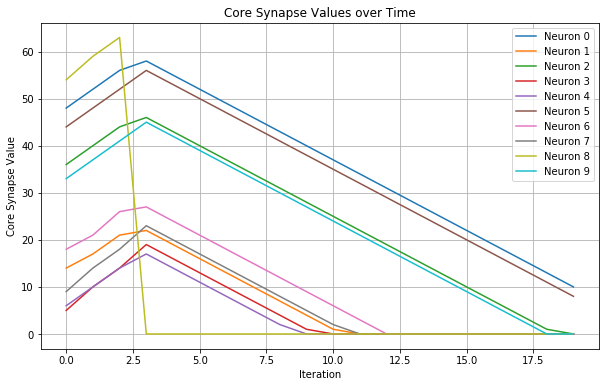

In [122]:
from time import sleep
num_neurons = 10
num_iterations = 20
relax = False;

readout = axi_direct_read.read(0)
# Initialize a matrix to store the core synapse values
core_synapse_values = np.zeros((num_neurons, num_iterations))
singleEvent = allocate(shape=(1,), dtype=np.uint32)
singleRelax = allocate(shape=(1,), dtype=np.uint32)
singleRelax[:] = TREFMASK
singleRelax.flush()

# Run the script multiple times and collect core synapse values
for iteration in range(num_iterations):
    if (relax):
        axi_dma.sendchannel.transfer(singleRelax)
        axi_dma.sendchannel.wait()
    else:
        singleEvent[0] = comboBuffer[::2][iteration]
        #singleEvent[1] = comboBuffer[(iteration*2) + 1]
        singleEvent.flush()
        axi_dma.sendchannel.transfer(singleEvent)
        axi_dma.sendchannel.wait()
        #axi_dma.sendchannel.transfer(singleRelax)
        #axi_dma.sendchannel.wait()
    sleep(.20)
    readout = axi_direct_read.read(0)
    print(readout, relax)
    if (readout & 0x80000000):
        relax = True;
    
    
    #Stop and read the neuron state.
    spi_loader(0, 1, ODIN_PROG_CONFIG)

    for i in range(num_neurons):
        x = spi_loader((8 << 8) + i, 0, ODIN_READ_NEURON)
        y = spi_loader((9 << 8) + i, 0, ODIN_READ_NEURON)
        total = ((y & 0x3F) << 2) | ((x & 0xC0) >> 6)
        core_synapse_values[i, iteration] = total

    spi_loader(0, 0, ODIN_PROG_CONFIG)

# Plot the core synapse values over time for each neuron
plt.figure(figsize=(10, 6))
for i in range(num_neurons):
    plt.plot(core_synapse_values[i], label=f"Neuron {i}")
plt.xlabel("Iteration")
plt.ylabel("Core Synapse Value")
plt.title("Core Synapse Values over Time")
plt.legend()
plt.grid(True)
plt.show()

### Animated version (takes longer to run)

0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
2147483655 False
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True


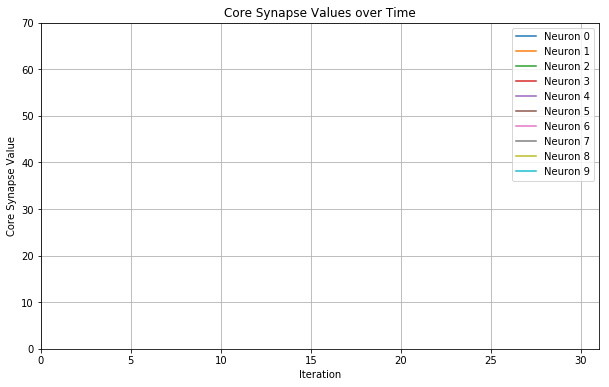

In [123]:
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

num_neurons = 10
num_iterations = 64
relax = False
readout = axi_direct_read.read(0)
window_size = 32  # Size of the sliding window

# Initialize a matrix to store the core synapse values
core_synapse_values = np.zeros((num_neurons, num_iterations))

singleEvent = allocate(shape=(2,), dtype=np.uint32)

# Run the script multiple times and collect core synapse values
for iteration in range(num_iterations):
    if relax:
        axi_dma.sendchannel.transfer(singleRelax)
    else:
        singleEvent[0] = comboBuffer[iteration * 2]
        singleEvent[1] = comboBuffer[(iteration * 2) + 1]
        singleEvent.flush()
        axi_dma.sendchannel.transfer(singleEvent)
    axi_dma.sendchannel.wait()
    sleep(.20)
    readout = axi_direct_read.read(0)
    print(readout, relax)
    if readout & 0x80000000:
        relax = True
    spi_loader(0, 1, ODIN_PROG_CONFIG)
    for i in range(num_neurons):
        x = spi_loader((8 << 8) + i, 0, ODIN_READ_NEURON)
        y = spi_loader((9 << 8) + i, 0, ODIN_READ_NEURON)
        total = ((y & 0x3F) << 2) | ((x & 0xC0) >> 6)
        core_synapse_values[i, iteration] = total
    spi_loader(0, 0, ODIN_PROG_CONFIG)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
lines = [ax.plot([], [], label=f"Neuron {i}")[0] for i in range(num_neurons)]
ax.set_xlim(0, window_size - 1)
ax.set_ylim(0, 70)
ax.set_xlabel("Iteration")
ax.set_ylabel("Core Synapse Value")
ax.set_title("Core Synapse Values over Time")
ax.legend()
ax.grid(True)

# Update function for the animation
def update(frame):
    start = max(0, frame - window_size + 1)
    end = frame + 1
    for i, line in enumerate(lines):
        y_data = core_synapse_values[i, start:end]
        line.set_data(np.arange(len(y_data)), y_data)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=num_iterations, blit=True, interval=100)


### Generate the animation

In [124]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [125]:
#Saveable
html_content = ani.to_jshtml()

with open('animation.html', 'w') as f:
    f.write(html_content)

In [126]:
nullBuffer.flush()
axi_dma.sendchannel.transfer(nullBuffer)
axi_dma.sendchannel.wait()

In [127]:
#How to read synaptic weights

spi_loader_mmio(0, 1, ODIN_PROG_CONFIG)
for i in range(num_neurons):
    x = spi_loader_mmio((8 << 8) + i, 0, ODIN_READ_NEURON)
    y = spi_loader_mmio((9 << 8) + i, 0, ODIN_READ_NEURON)
    total = ((y & 0x3F) << 2) | ((x & 0xC0) >> 6)
    print(i,total)
spi_loader_mmio(0, 0, ODIN_PROG_CONFIG)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


0

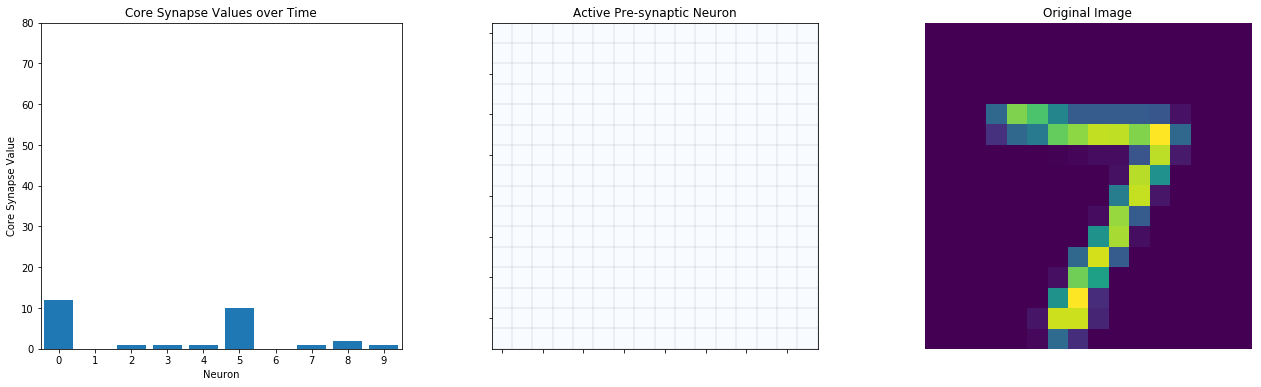

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from pynq import Overlay
from pynq import allocate
from time import sleep

# Load the AER data from the JSON file
with open("data/aer_data.json", "r") as json_file:
    aer_data = json.load(json_file)["aer_data"]

original_images = [np.array(data["original_image"]).reshape(16, 16) for data in aer_data]

num_neurons = 10
num_iterations = 30

fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(22, 6))

# Initialize the bar chart
bars = ax1.bar(range(num_neurons), core_synapse_values[:, 0])
ax1.set_xlabel("Neuron")
ax1.set_ylabel("Core Synapse Value")
ax1.set_title("Core Synapse Values over Time")
ax1.set_xlim([-0.5, num_neurons - 0.5])
ax1.set_ylim([0, 80])
ax1.set_xticks(range(num_neurons))
#x1.set_xticklabels([f"{i}" for i in range(num_neurons)])

# Initialize the original image heatmap
heatmap_original = ax2.imshow(original_images[0], cmap='viridis', interpolation='nearest')
ax2.axis('off')
ax2.set_title("Original Image")

# Initialize the active synapse heatmap
active_synapse_image = np.zeros((16, 16))
highlight = np.zeros_like(active_synapse_image)
heatmap_active_synapse = ax3.imshow(active_synapse_image, cmap='binary', interpolation='nearest', vmin=0, vmax=1)
highlight_map = ax3.imshow(highlight, cmap='Blues', interpolation='nearest', vmin=0, vmax=1, alpha=0.8)
ax3.set_xticks(np.arange(-0.5, 16, 1), minor=True)
ax3.set_yticks(np.arange(-0.5, 16, 1), minor=True)
ax3.grid(which='minor', color='gray', linestyle='-', linewidth=0.2)
ax3.tick_params(which='minor', length=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_title("Active Pre-synaptic Neuron")

relax = True
current_input = 0
countdown = 0
frame_true = -1
inferred = 0
# Initialize a matrix to store the core synapse values
core_synapse_values = np.zeros((num_neurons, num_iterations))

singleEvent = allocate(shape=(2,), dtype=np.uint32)
singleRelax = allocate(shape=(1,), dtype=np.uint32)
singleRelax[:] = TREFMASK

def init():
    global active_synapse_image
    active_synapse_image = np.zeros((16, 16))
    return [bars, heatmap_original, heatmap_active_synapse, highlight_map]

# Update function for the animation
def update(frame):
    global active_synapse_image
    global relax
    global current_input
    global countdown
    global frame_true
    global inferred
    
    frame_true += 1
    if (relax == True and countdown == 0):
        relax = False
        print(relax, current_input)
        for i in range(256):
            comboBuffer[i*2] = ((aer_codes[current_input][i] & 0x000000FF) << 8) | SPKEMASK
            comboBuffer[(i*2) + 1] = TREFMASK
        comboBuffer.flush()
        heatmap_original.set_data(original_images[current_input])
        current_input += 1
        frame_true = 0
    
    #if current_input == 2:
    #    current_input += 1
    
    if relax:
        axi_dma.sendchannel.transfer(singleRelax)
    else:
        singleEvent[0] = comboBuffer[frame_true * 2]
        singleEvent[1] = comboBuffer[(frame_true * 2) + 1]
        singleEvent.flush()
        axi_dma.sendchannel.transfer(singleEvent)
    axi_dma.sendchannel.wait()
    sleep(.20)

    readout = axi_direct_read.read(0)
    print(readout, relax)

    if readout & 0x80000000:
        relax = True
        countdown = 24
        inferred = readout & 0x000000FF
    
    countdown -= 1
    

    spi_loader_mmio(0, 1, ODIN_PROG_CONFIG)

    for i in range(num_neurons):
        x = spi_loader_mmio((8 << 8) + i, 0, ODIN_READ_NEURON)
        y = spi_loader_mmio((9 << 8) + i, 0, ODIN_READ_NEURON)
        total = ((y & 0x3F) << 2) | ((x & 0xC0) >> 6)
        core_synapse_values[i, frame] = total

    spi_loader_mmio(0, 0, ODIN_PROG_CONFIG)

    for bar, height in zip(bars, core_synapse_values[:, frame]):
        bar.set_height(height)

    ax1.set_title(f"Core Synapse Values - Time Step {frame+1}")

    if relax:
        ax2.set_title(f"Original Image | Inferred: {inferred}")
    else:
        ax2.set_title(f"Original Image | Inferred: ...")
        
    aer_code = (singleEvent[0] >> 8) & 0xFF
    row = aer_code // 16
    col = aer_code % 16

    active_synapse_image = np.clip(active_synapse_image - 0.1, 0, None)
    if relax:
        active_synapse_image[row, col] = 0
        ax3.set_title(f"Active Synapse - TREF (no input)")
    else:
        active_synapse_image[row, col] = 1
        ax3.set_title(f"Active Synapse - {aer_code}")

    highlight = np.zeros_like(active_synapse_image)
    if not relax:
        highlight[row, col] = 1

    highlight_map.set_data(highlight)
    heatmap_active_synapse.set_data(active_synapse_image)



    return [bars, heatmap_original, heatmap_active_synapse, highlight_map]

# Create the animation
ani = FuncAnimation(fig, update, frames=num_iterations, interval=100, blit=False, init_func=init)


In [129]:
HTML(ani.to_jshtml())

False 0
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False


### View synaptic weights, graphically

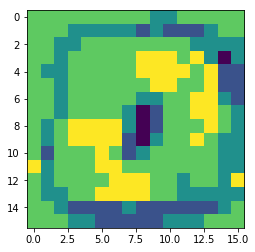

In [130]:
spi_loader_mmio(0, 1, ODIN_PROG_CONFIG)  

weightmap  = []

neuron_num = 0
for i in range(256):
    synapse = i % 32
    spi_base_address= i * 32
    byte_offset = (neuron_num//2) % 4
    nibble_offset = neuron_num % 2
    row_offset = (neuron_num % 32) // 8
    spi_address = (byte_offset << 13) + row_offset + spi_base_address
    
    readback = spi_loader_mmio(spi_address, 0, ODIN_READ_SYNAPSE)
    if (nibble_offset == 1):
        weight = readback >> 4
    else:
        weight = readback
    weight &= 0x00000007
    
    weightmap.append(weight)
    
spi_loader_mmio(0, 0, ODIN_PROG_CONFIG)  

np_weightmap = np.array(weightmap).reshape(16,16)

plt.imshow(np_weightmap, cmap='viridis', interpolation='nearest')
plt.show()
